# Computer Vision Challenges

In [1]:
# import the library
import cv2
import numpy as np
import imutils 
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from IPython import display


plt.ion()

## Challenge 1: Detect the number of floors

   assume 1 floor is equal to 1 box 

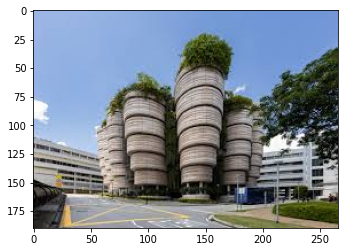

In [2]:
image = cv2.imread('./images/hive.jpg',-1)
# Change the format of photo from BGR TO RGB
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

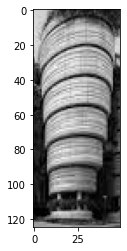

In [3]:
# Extract the region of interest(roi). 
roi = image[45:170,120:170]
#conver to gray as we dont need color to detect the contour 
gray=cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
plt.gray()
plt.imshow(gray)


In [4]:
# In order to reduce noise in a image, smoothing (blurring ) is used.
# Increasing the kernel size make it more blurry. If kernel size is too high, edges might be blurred
# The higher the sigma, the blurry the image will be.

# There's 4 different types of blur filter for you to choose, 
# median blur is good for solving salt and pepper noise
# blur is average the value in the kernel size to the middle 
# gaussian is just make it a bell curve, the side will have lower value
# bilateral will preserve the edge better than the rest of the blurring filter
image=gray.copy()


def blur_image(choice=1,kernel_size=5,sigma=1):
    plt.figure(figsize=(7,7))
    global blurred
    if(choice==1):
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    elif choice==2:
        blurred = cv2.medianBlur(image,kernel_size,sigma)
    elif choice==3:
        blurred = cv2.blur(image, (kernel_size, kernel_size),sigma)
    elif choice==4:
        blurred = cv2.bilateralFilter(image,kernel_size,sigma,sigma)

    plt.imshow(blurred)
    return blurred    


blur_fn=interact(blur_image,choice=[('gaussian', 1), ('median', 2),("blur",3),("bilateral",4)],kernel_size=(1,15,2),sigma=(0,100,0.1))
#get the image from the function
blurred= blur_fn.widget.result

interactive(children=(Dropdown(description='choice', options=(('gaussian', 1), ('median', 2), ('blur', 3), ('b…

### Approach 1: using edges to find floor

In [5]:

# this website consist of good explaination on the Hysteresis Thresholding of canny edges
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html

# get the contour by adjusting suitable range of thresholding
# I perfomed morphology(erode after dilate ) to close the broken link of edges
# get the contours

to_canny=blurred.copy()
ori_image=roi.copy()

def edges_contour(thres1=30,thres2=314,min_area=126,iterat=1,max_area=1063):
    f, axes = plt.subplots(1,3,figsize=(10,10))
    edged = cv2.Canny(to_canny, thres1, thres2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    
    # perform morph_close which is erode after dilate ( purpose is to close the broken edges)
    # I think broken down to dilate and erode will be better as we can have a better control
    close = cv2.morphologyEx(edged, cv2.MORPH_CLOSE  ,kernel,iterations=iterat)
    contours, hierarchy = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    output = ori_image.copy()
    #only get the contours within a range of area
    contours = [c for c in contours if cv2.contourArea(c)> min_area and (cv2.contourArea(c))< max_area]
    cv2.drawContours(output, contours, -1, (240, 0, 0), 1)
    
    axes[0].imshow(edged)
    axes[0].set_title("Canny Edges")
    axes[1].imshow(close)
    axes[1].set_title("After Morphology")
    axes[2].imshow(output)
    axes[2].set_title("Contour")

    print(str(len(contours))+" floors")


interact(edges_contour,thres1=(0,1000),thres2=(0,1000),min_area=(0,1000),iterat=(0,10),max_area=(0,3000))

interactive(children=(IntSlider(value=30, description='thres1', max=1000), IntSlider(value=314, description='t…

<function __main__.edges_contour(thres1=30, thres2=314, min_area=126, iterat=1, max_area=1063)>

### Approach 2 : Using thresholding method.

In [6]:
#using threshold to find contour basically setting the value lower than a certain threshold to 255(black)
# For this case, the intensity of the sky is close to the intensity of the building,(gray color) 
# This method is sensitive to intensity of the pixel.


to_thresh=blurred.copy()
ori_image=roi.copy()

def threshold_contour(thresh_val=116,contour_min_area=42):
    f, axes = plt.subplots(1,3,figsize=(10,10))
    thresh = cv2.threshold(to_thresh,thresh_val,255,cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = [c for c in cnts if cv2.contourArea(c)> contour_min_area]
    output = ori_image.copy()
    cv2.drawContours(output, cnts, -1, (240, 0, 159),1)
    axes[0].imshow(gray)
    axes[0].set_title("Original")
    axes[1].imshow(thresh)
    axes[1].set_title("Threshold image")
    axes[2].imshow(output)
    axes[2].set_title("contour image")
    return thresh
    
thresh_fn=interact(threshold_contour,thresh_val=(0,255),contour_min_area=(0,200))
thresh=thresh_fn.widget.result

interactive(children=(IntSlider(value=116, description='thresh_val', max=255), IntSlider(value=42, description…

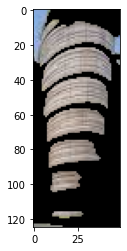

In [7]:
mask = thresh.copy()
output = cv2.bitwise_and(roi, roi, mask=mask)
plt.imshow(output)

### Approach 3 : Using Hough Lines P

In [8]:
#  Had an idea of using hough line to detect horizontal line to detect number of floor
# however, it's not suitable in this case as the line is not straight? I guess.

def hough(thres1=30,thres2=314,threshold=0):
    f, axes = plt.subplots(1,2,figsize=(6,6))
    edged = cv2.Canny(blurred, thres1, thres2)
    lines = cv2.HoughLines(edged,1,np.pi/180,threshold)
    img = roi.copy()
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    axes[0].imshow(edged)
    axes[0].set_title("Canny Edges")
    axes[1].imshow(img)
    axes[1].set_title("Hough")


interact(hough,thres1=(0,1000),thres2=(0,1000),threshold=(0,255))


interactive(children=(IntSlider(value=30, description='thres1', max=1000), IntSlider(value=314, description='t…

<function __main__.hough(thres1=30, thres2=314, threshold=0)>

## QUESTIONS 

**1. I realised that using the threshold function to seperate the object and background is sufficient to get the contour. What do you think?**

As you know the OpenCv contour finder is standard. However, prior processings on the image are very important and can make significant changes on the contours. As for the `findContours` function, I would suggest that you try out its different options to have better understanding of the different methods used to extract image contours.

The pre-processing steps depends on the image. For this particular example you have implemented good steps. We usually convert image to grayscale when colors are not of high importance. `Gaussian blur` and extrating edges using `Canny Edges` are also useful which you have done, but sometimes they don't help. You should always plug and unplug them to see what gives better result. In this example you can observe that you haven't used your `edged` image for contours and yet you have produced good contours.

**2. what is the usage of edges? For this case, it does not help?**

Edges can be helpful when thresholded image cannot be produced with good results. But edges are also very useful when you want to detect lines, cirlces, and such.

**3. The blue background is affecting my contour, What i thought of was changing/removing the blue background before i proceed, But im not sure how to do.**

You can mask out the blue sky by masking out its color. You can use the `inRange` function. It's important that you provide good low and high thresholds for this function. Since the image's color are always not perfect (for examply the sky is not a perfect blue), you should either write a code to extract the min/max values within a region or by simply displaying the image window using `imshow` and hover your mouse over the region to observe the min/max color values. Playing the `hue`, `saturation`, and `illumination` (`HSI`) are also helpful besides `RGB`. In most cases `HSI` is more accurate than `RGB`. `HSV` can also be considered for some images. Besides the blue sky I would also mask out the trees.

**4. I remember our lab uses HSV to get certain colour. So what if I tune to get a blue mask and mask it with the original photo to remove the background, does it work that way?**
<br>Haha I answered this question above. Yes, you should use this methos to mask out the sky.

**5. For Hough line, I really dont know how to tune it .**
<br>`Hough` has its own limitations. In other words, it expects a good (nearly perfect) image as its input. So, pre-processing for `Hough` is more important than its own parameters. 

 **any improvement that i can make? or alternative way**
 
 I think you already mentioned yourself to improve the result by removing the sky. I would recommend to remove the trees as well. Other than this, everything else that you have done is pretty good.
 
 ### Some Genereal Feedbacks
 - Good job in creating ROI. This makes image processing very efficient specially when the entire image is not required to be processed.
 - Try playing around with thresholding using colors (RGB, HSI, HSV). You will find that HSI is quite strong. But it's important to play with them and observe the resulting images. It will make a lot of sense to you when you start playing with parameters and visualizing the effects.

# Challenge 2: Circle Detection


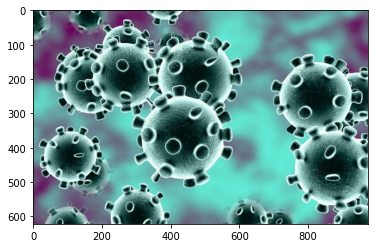

In [9]:
# count number of coron 
corona = cv2.imread('./images/corona.jpg',-1)
corona=cv2.cvtColor(corona, cv2.COLOR_BGR2RGB)
plt.imshow(corona[:,:])
plt.gray()
plt.show(block=False)

In [10]:
gray=cv2.cvtColor(corona, cv2.COLOR_RGB2GRAY)
image=gray.copy()


def blur_image(choice=1,kernel_size=9,sigma=52):
    plt.figure(figsize=(7,7))
    if(choice==1):
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    elif choice==2:
        blurred = cv2.medianBlur(image,kernel_size,sigma)
    elif choice==3:
        blurred = cv2.blur(image, (kernel_size, kernel_size),sigma)
    elif choice==4:
        blurred = cv2.bilateralFilter(image,kernel_size,sigma,sigma)
        
    plt.imshow(blurred)
    return blurred

blur_fn=interact(blur_image,choice=[('gaussian', 1), ('median', 2),("blur",3),("bilateral",4)],kernel_size=(1,15,2),sigma=(0,200,0.1))
#get the image from the function
blurred= blur_fn.widget.result


interactive(children=(Dropdown(description='choice', options=(('gaussian', 1), ('median', 2), ('blur', 3), ('b…

## Approach 1 : Hough Circle 

In [11]:
# This require a lot of tuning, param 1 is the canny threshold 2, u should visualize it to get a good enough threshold
# param 2 is the minimum distance between each circle center, if too low, more false circle will appear
# minRadius and maxRadius set the min,max radius of circle allowed 

to_canny=blurred.copy()
ori_image=corona.copy()

def hough_circle(canny_high=72,cir_ctr_thres=22,min_rad=68,max_rad=115):
    output=ori_image.copy()
    f, axes = plt.subplots(1,2,figsize=(15,15))
    edged = cv2.Canny(to_canny, canny_high/2, canny_high)
    circles=cv2.HoughCircles(to_canny,  cv2.HOUGH_GRADIENT, 1,70,param1=canny_high,param2=cir_ctr_thres,minRadius=min_rad,maxRadius=max_rad)
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        print(str(circles.shape[0])+ " Circles")
        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # draw the circle in the output image, then draw a rectangle
            # corresponding to the center of the circle
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    axes[0].imshow(edged)
    axes[0].set_title("Canny Edges")
    axes[1].imshow(output)
    axes[1].set_title("Hough")


interact(hough_circle,canny_high=(0,255),cir_ctr_thres=(0,255),min_rad=(0,255),max_rad=(0,255))


interactive(children=(IntSlider(value=72, description='canny_high', max=255), IntSlider(value=22, description=…

<function __main__.hough_circle(canny_high=72, cir_ctr_thres=22, min_rad=68, max_rad=115)>

## Approach 2: Thresholding method

In [12]:
# This will not be a good method as it's very sensitive to the intensity
# Although we can get more circle but it is "tuned" perfectly to get this result.b
to_thresh=blurred.copy()
ori_image=corona.copy()

def threshold_contour(thresh_val=60,contour_min_area=11,contour_max_area=200):
    f, axes = plt.subplots(2,2,figsize=(20,20))
    thresh = cv2.threshold(to_thresh,thresh_val,255,cv2.THRESH_BINARY_INV)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = [c for c in cnts if cv2.contourArea(c)/100> contour_min_area and cv2.contourArea(c)/100<contour_max_area]
    output = ori_image.copy()
    print(str(len(cnts))+ " Circles")
    cv2.drawContours(output, cnts, -1, (240, 0, 159),2)
    axes[0,0].imshow(gray)
    axes[0,0].set_title("Original")
    axes[0,1].imshow(thresh)
    axes[0,1].set_title("Threshold image")
    axes[1,0].imshow(output)
    axes[1,0].set_title("contour image")

    
interact(threshold_contour,thresh_val=(0,255),contour_min_area=(0,200),contour_max_area=(0,200))

interactive(children=(IntSlider(value=60, description='thresh_val', max=255), IntSlider(value=11, description=…

<function __main__.threshold_contour(thresh_val=60, contour_min_area=11, contour_max_area=200)>

 I prefer the hough circle method in this case.

## Questions

**1. Actually right, when I perform image smothing to reduce the noise, What kind of graph of image should I get? like how do i know the reduction of noise if enough?**

<br>Generally speaking you should not see too many outliers. In other words, it should look like an even distribution. But it's not always the case! You can never know when it is actually enough other than checking the resultant image and further play with parameters if needed.

**2. The hough transform is easily affected by the noise, so I need to apply good enough gaussian blur to make it work. this algorithm require a lot of tuning. I dont feel like it's very feasible in real life when there's a lot of noise.**

<br>You are exactly right and that's why deep learning performs better than conventional image processing. As you gain experience you would know which noise deduction techniques to use. So, it's quite normal for you to be frustrated with what works well and how well. Besides `Gaussian Blur`, I'd suggest that you try out `dilate` and `erode` as well. I also suggest you search and read about image segmentation with OpenCV.


There different types of thresholdings. But, since you started your computer vision journey with deep learning you'll get frustrated with image processing techniques. Be patient and play with more challenging examples. In time, you will know what methods to use when seeing an image. However, in many cases, we will have to use try and error methods. As you get experienced with different images, you can do it much faster.

**Are there any other method ? How can i improve?**

I think I mentioned some suggestions above. By the way, OpenCV 4 has been released. I haven't had the time to check the improvements. Check it out when you can.

# Challenge 3: Object Detection by color 

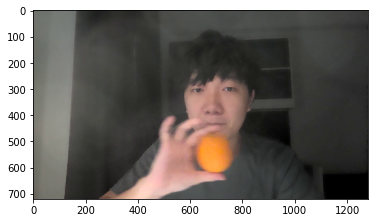

In [13]:
cap = cv2.VideoCapture('./images/Color_detection.mp4')
# extract a frame from a video
cap.set(1,100); # Where frame_no is the frame you want

ret, frame = cap.read()
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)



In [14]:

# Play around with HSV. HSV is useful if you want to object detection based on colour or masked out certain colour.
# The Hue is the range of color, you can easily convert rgb to hue range online
# The saturation and value , you can just play around the get the right range 
def HSV_range(l_h=0, l_s=110, l_v=100,u_h=40, u_s=255, u_v=255):
    f, axes = plt.subplots(1,2,figsize=(15,15))
    hsv=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_hsv = np.array([l_h, l_s, l_v])
    higher_hsv = np.array([u_h, u_s, u_v])
    mask = cv2.inRange(hsv, lower_hsv, higher_hsv)
    frame = cv2.bitwise_and(img.copy(), img.copy(), mask=mask)
    axes[0].imshow(mask)
    axes[0].set_title("hsv mask")
    axes[1].imshow(frame)
    axes[1].set_title("Bitwise_and with ori")
    return mask
HSV_fn=interact(HSV_range,l_h=(0,180), l_s=(0,255), l_v=(0,255),u_h=(0,180), u_s=(0,255), u_v=(0,255))
# get the mask 
hsv_mask= HSV_fn.widget.result

interactive(children=(IntSlider(value=0, description='l_h', max=180), IntSlider(value=110, description='l_s', …

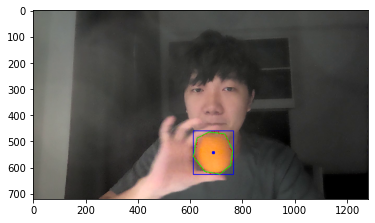

In [15]:

cnts = cv2.findContours(hsv_mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# only extract the contour with area larger than certain area to remove noise
cnts = [c for c in cnts if cv2.contourArea(c)> 100]
output = img.copy()
for c in cnts:
    # red is the contour detected
    cv2.drawContours(output, c, -1, (255, 0, 0),2)
    x,y,w,h=cv2.boundingRect(c)
    # let's draw a rectangle over the detected contour
    cv2.rectangle(output,(x,y),(x+w,y+h),(0,0,255),2)
    cv2.circle(output,(int(x+w/2),int(y+h/2)),1,(0,0,255),10)
    #calculate accuracy as a percent of contour perimeter
    accuracy=0.02*cv2.arcLength(c,True)
    #green is the approx contour 
    approx=cv2.approxPolyDP(c,accuracy,True)
    cv2.drawContours(output,[approx],0,(0,255,0),2)
    plt.imshow(output)


Basically, all we need to do is:
1. getting the range of hsv to detect certain colour,
2. then we can create a mask and mask out the object
3. find the contour of it ( Can blur the image beforehand to eliminate noise )
4. Create a bounding box for the detected object.( if necessary)

# Challenge 4 : Object detection by template matching
Limitation : It doesn't work if the object is rotated/sheared compared to the template image

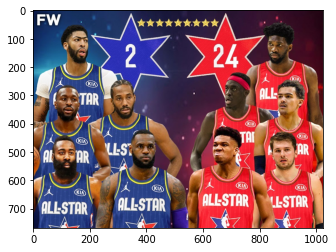

In [16]:
nba=cv2.imread("./images/NBA_All_Star.jpg")
nba=cv2.cvtColor(nba,cv2.COLOR_BGR2RGB)
plt.imshow(nba)

In [17]:
# extract lebron face from the photo
ori_image= nba.copy()
width, height = ori_image.shape[:-1]

def get_roi(x_low=335,x_high=440,y_low=420,y_high=560):
    # in opencv, it's is row:col(y:x) instead of x:y
    roi=ori_image[y_low:y_high,x_low:x_high]
    plt.imshow(roi)
    return roi
    
    
roi_fn=interact(get_roi,x_low=(0,height), x_high=(0,height), y_low=(0,width),y_high=(0,width))
lebron=roi_fn.widget.result 

interactive(children=(IntSlider(value=335, description='x_low', max=1024), IntSlider(value=440, description='x…

105


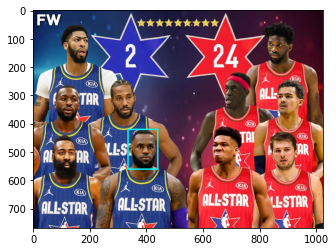

In [18]:

h, w,_ = np.shape(lebron)

gray_img = cv2.cvtColor(nba, cv2.COLOR_RGB2GRAY) 
lebron_gray = cv2.cvtColor(lebron, cv2.COLOR_RGB2GRAY) 

# we can use gray image to perform template matching as color doesnt matter in this case. but rgb works fine as well
result = cv2.matchTemplate(gray_img,lebron_gray,cv2.TM_CCOEFF_NORMED) 
# set the accuracy threshold to 0.9
threshold=0.9
loc = np.where( result >= threshold)  
print(w)
final_image=nba.copy()
for pt in zip(*loc[::-1]): 
    cv2.rectangle(final_image, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2) 
  
plt.imshow(final_image)


This is useful if the size,angle,rotation of the objects are all the same. 

## Eye blinking detection, line detection for road, Face detection, 

# Challenge 5 : Document Scanner 


Convert image to grayscale and median blur to smooth image
Sharpen image to enhance edges
Threshold
Perform morphological transformations
Find contours and filter using minimum/maximum threshold area

STEP 1: Edge Detection


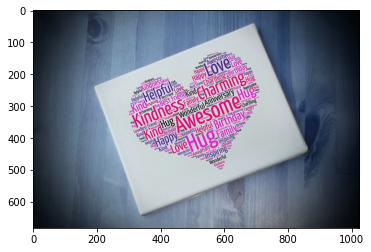

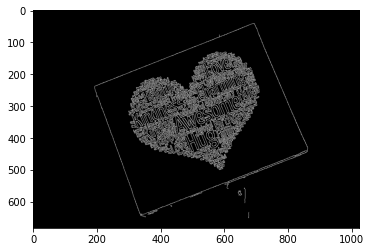

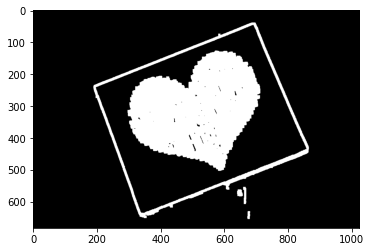

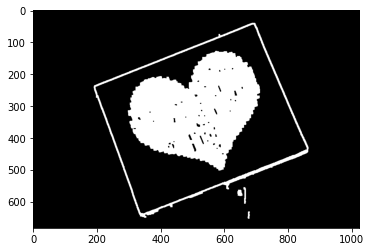

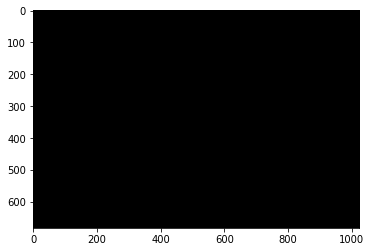

In [19]:
#https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/
image = cv2.imread("./images/a42.jpg")
# ratio = image.shape[0] / 500.0
# orig = image.copy()
#image = imutils.resize(image, height = 500)
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(blur, -1, sharpen_kernel)
edged = cv2.Canny(gray, 75, 200)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

dilated=cv2.dilate(edged, kernel, iterations=3)
eroded= cv2.erode(dilated, kernel, iterations=1)
thresh = cv2.threshold(edged,160,255, cv2.THRESH_BINARY_INV)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
# show the original image and the edge detected image
print("STEP 1: Edge Detection")
plt.imshow(image)
plt.show(block=True)

plt.imshow(edged)
plt.show(block=True)
plt.imshow(dilated)
plt.show(block=True)
plt.imshow(eroded)
plt.show(block=True)

plt.imshow(close)
plt.show(block=True)



STEP 2: Find contours of paper


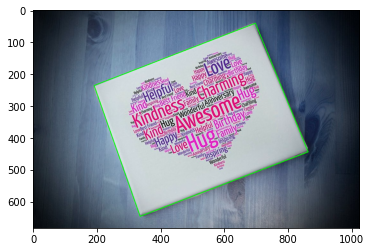

In [20]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour

cnts = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
found=False
min_area = 100
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02* peri, True)
    #print(approx)
    # area = cv2.contourArea(approx)
    # if area > min_area :
    #     x,y,w,h = cv2.boundingRect(approx)
    #     ROI = image[y:y+h, x:x+h]
    #     plt.imshow(ROI)
    #     plt.show(block=True)


    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        found=True
        break
# if never found 4 corner object, assume it's full screen
if not found:
    # return [0,0,0,image.size[1],image.size[0],image.size[1],image.size[0],0]
    print("not found")
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
# print(screenCnt)
plt.imshow(image)


In [21]:
print([i for i in screenCnt.flatten()])
print(image.shape[0])
print(type(i for i in screenCnt.flatten()))

[696, 41, 191, 236, 335, 646, 861, 444]
683
<class 'generator'>


In [22]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [23]:
#https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

STEP 3: Apply perspective transform


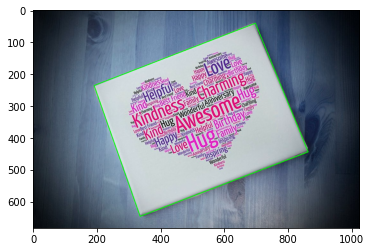

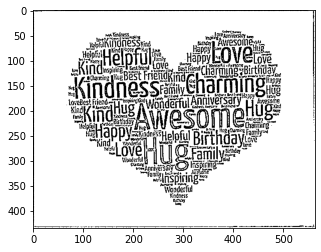

In [24]:
from skimage.filters import threshold_local
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(image, screenCnt.reshape(4, 2))
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
# show the original and scanned images
print("STEP 3: Apply perspective transform")

plt.imshow(image)
plt.show(block=True)

plt.imshow(warped)
plt.show(block=True)

In [25]:
#https://github.com/endalk200/document-scanner/blob/ab200b99789d2252a274ee1b7a21ff1eaadc4c43/scan.py#L60
from pylsd2 import LineSegmentDetectionED
import itertools
import math
from scipy.spatial import distance as dist
import os

class DocScanner(object):
    """An image scanner"""
    def __init__(self, interactive=False, MIN_QUAD_AREA_RATIO=0.25, MAX_QUAD_ANGLE_RANGE=40):
        """
          Args:
            interactive (boolean): If True, user can adjust screen contour before
                transformation occurs in interactive pyplot window.
            MIN_QUAD_AREA_RATIO (float): A contour will be rejected if its corners 
                do not form a quadrilateral that covers at least MIN_QUAD_AREA_RATIO 
                of the original image. Defaults to 0.25.
            MAX_QUAD_ANGLE_RANGE (int):  A contour will also be rejected if the range 
                of its interior angles exceeds MAX_QUAD_ANGLE_RANGE. Defaults to 40.
        """        
        self.interactive = interactive
        self.MIN_QUAD_AREA_RATIO = MIN_QUAD_AREA_RATIO
        self.MAX_QUAD_ANGLE_RANGE = MAX_QUAD_ANGLE_RANGE        

    def filter_corners(self, corners, min_dist=20):
        """Filters corners that are within min_dist of others"""
        def predicate(representatives, corner):
            return all(dist.euclidean(representative, corner) >= min_dist
                       for representative in representatives)

        filtered_corners = []
        for c in corners:
            if predicate(filtered_corners, c):
                filtered_corners.append(c)
        return filtered_corners

    def angle_between_vectors_degrees(self, u, v):
        """Returns the angle between two vectors in degrees"""
        return np.degrees(
            math.acos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))))

    def get_angle(self, p1, p2, p3):
        """
        Returns the angle between the line segment from p2 to p1 
        and the line segment from p2 to p3 in degrees
        """
        a = np.radians(np.array(p1))
        b = np.radians(np.array(p2))
        c = np.radians(np.array(p3))

        avec = a - b
        cvec = c - b

        return self.angle_between_vectors_degrees(avec, cvec)

    def angle_range(self, quad):
        """
        Returns the range between max and min interior angles of quadrilateral.
        The input quadrilateral must be a numpy array with vertices ordered clockwise
        starting with the top left vertex.
        """
        tl, tr, br, bl = quad
        ura = self.get_angle(tl[0], tr[0], br[0])
        ula = self.get_angle(bl[0], tl[0], tr[0])
        lra = self.get_angle(tr[0], br[0], bl[0])
        lla = self.get_angle(br[0], bl[0], tl[0])

        angles = [ura, ula, lra, lla]
        return np.ptp(angles)          

    def get_corners(self, img):
        """
        Returns a list of corners ((x, y) tuples) found in the input image. With proper
        pre-processing and filtering, it should output at most 10 potential corners.
        This is a utility function used by get_contours. The input image is expected 
        to be rescaled and Canny filtered prior to be passed in.
        """
        lines = LineSegmentDetectionED(img)

        # massages the output from LSD
        # LSD operates on edges. One "line" has 2 edges, and so we need to combine the edges back into lines
        # 1. separate out the lines into horizontal and vertical lines.
        # 2. Draw the horizontal lines back onto a canvas, but slightly thicker and longer.
        # 3. Run connected-components on the new canvas
        # 4. Get the bounding box for each component, and the bounding box is final line.
        # 5. The ends of each line is a corner
        # 6. Repeat for vertical lines
        # 7. Draw all the final lines onto another canvas. Where the lines overlap are also corners

        corners = []
        if lines is not None:
            # separate out the horizontal and vertical lines, and draw them back onto separate canvases
            lines = lines.squeeze().astype(np.int32).tolist()
            horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for line in lines:
                x1, y1, x2, y2 = line[:4]
                if abs(x2 - x1) > abs(y2 - y1):
                    (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[0])
                    cv2.line(horizontal_lines_canvas, (max(x1 - 5, 0), y1), (min(x2 + 5, img.shape[1] - 1), y2), 255, 2)
                else:
                    (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[1])
                    cv2.line(vertical_lines_canvas, (x1, max(y1 - 5, 0)), (x2, min(y2 + 5, img.shape[0] - 1)), 255, 2)

            lines = []

            # find the horizontal lines (connected-components -> bounding boxes -> final lines)
            (contours, hierarchy) = cv2.findContours(horizontal_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
            horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for contour in contours:
                contour = contour.reshape((contour.shape[0], contour.shape[2]))
                min_x = np.amin(contour[:, 0], axis=0) + 2
                max_x = np.amax(contour[:, 0], axis=0) - 2
                left_y = int(np.average(contour[contour[:, 0] == min_x][:, 1]))
                right_y = int(np.average(contour[contour[:, 0] == max_x][:, 1]))
                lines.append((min_x, left_y, max_x, right_y))
                cv2.line(horizontal_lines_canvas, (min_x, left_y), (max_x, right_y), 1, 1)
                corners.append((min_x, left_y))
                corners.append((max_x, right_y))

            # find the vertical lines (connected-components -> bounding boxes -> final lines)
            (contours, hierarchy) = cv2.findContours(vertical_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
            vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for contour in contours:
                contour = contour.reshape((contour.shape[0], contour.shape[2]))
                min_y = np.amin(contour[:, 1], axis=0) + 2
                max_y = np.amax(contour[:, 1], axis=0) - 2
                top_x = int(np.average(contour[contour[:, 1] == min_y][:, 0]))
                bottom_x = int(np.average(contour[contour[:, 1] == max_y][:, 0]))
                lines.append((top_x, min_y, bottom_x, max_y))
                cv2.line(vertical_lines_canvas, (top_x, min_y), (bottom_x, max_y), 1, 1)
                corners.append((top_x, min_y))
                corners.append((bottom_x, max_y))

            # find the corners
            corners_y, corners_x = np.where(horizontal_lines_canvas + vertical_lines_canvas == 2)
            corners += zip(corners_x, corners_y)

        # remove corners in close proximity
        corners = self.filter_corners(corners)
        return corners

    def is_valid_contour(self, cnt, IM_WIDTH, IM_HEIGHT):
        """Returns True if the contour satisfies all requirements set at instantitation"""

        return (len(cnt) == 4 and cv2.contourArea(cnt) > IM_WIDTH * IM_HEIGHT * self.MIN_QUAD_AREA_RATIO 
            and self.angle_range(cnt) < self.MAX_QUAD_ANGLE_RANGE)


    def get_contour(self, rescaled_image):
        """
        Returns a numpy array of shape (4, 2) containing the vertices of the four corners
        of the document in the image. It considers the corners returned from get_corners()
        and uses heuristics to choose the four corners that most likely represent
        the corners of the document. If no corners were found, or the four corners represent
        a quadrilateral that is too small or convex, it returns the original four corners.
        """

        # these constants are carefully chosen
        MORPH = 9
        CANNY = 84
        HOUGH = 25

        IM_HEIGHT, IM_WIDTH, _ = rescaled_image.shape

        # convert the image to grayscale and blur it slightly
        gray = cv2.cvtColor(rescaled_image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7,7), 0)

        # dilate helps to remove potential holes between edge segments
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(MORPH,MORPH))
        dilated = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

        # find edges and mark them in the output map using the Canny algorithm
        edged = cv2.Canny(dilated, 0, CANNY)
        test_corners = self.get_corners(edged)

        approx_contours = []

        if len(test_corners) >= 4:
            quads = []

            for quad in itertools.combinations(test_corners, 4):
                points = np.array(quad)
                points = order_points(points)
                points = np.array([[p] for p in points], dtype = "int32")
                quads.append(points)

            # get top five quadrilaterals by area
            quads = sorted(quads, key=cv2.contourArea, reverse=True)[:5]
            # sort candidate quadrilaterals by their angle range, which helps remove outliers
            quads = sorted(quads, key=self.angle_range)

            approx = quads[0]
            if self.is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
                approx_contours.append(approx)

            # for debugging: uncomment the code below to draw the corners and countour found 
            # by get_corners() and overlay it on the image

            # cv2.drawContours(rescaled_image, [approx], -1, (20, 20, 255), 2)
            # plt.scatter(*zip(*test_corners))
            # plt.imshow(rescaled_image)
            # plt.show()

        # also attempt to find contours directly from the edged image, which occasionally 
        # produces better results
        (cnts, hierarchy) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

        # loop over the contours
        for c in cnts:
            # approximate the contour
            approx = cv2.approxPolyDP(c, 80, True)
            if self.is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
                approx_contours.append(approx)
                break

        # If we did not find any valid contours, just use the whole image
        if not approx_contours:
            TOP_RIGHT = (IM_WIDTH, 0)
            BOTTOM_RIGHT = (IM_WIDTH, IM_HEIGHT)
            BOTTOM_LEFT = (0, IM_HEIGHT)
            TOP_LEFT = (0, 0)
            screenCnt = np.array([[TOP_RIGHT], [BOTTOM_RIGHT], [BOTTOM_LEFT], [TOP_LEFT]])

        else:
            screenCnt = max(approx_contours, key=cv2.contourArea)
            
        return screenCnt.reshape(4, 2)

    def interactive_get_contour(self, screenCnt, rescaled_image):
        poly = Polygon(screenCnt, animated=True, fill=False, color="yellow", linewidth=5)
        fig, ax = plt.subplots()
        ax.add_patch(poly)
        ax.set_title(('Drag the corners of the box to the corners of the document. \n'
            'Close the window when finished.'))
        p = poly_i.PolygonInteractor(ax, poly)
        plt.imshow(rescaled_image)
        plt.show()

        new_points = p.get_poly_points()[:4]
        new_points = np.array([[p] for p in new_points], dtype = "int32")
        return new_points.reshape(4, 2)

    def scan(self, image_path):

        RESCALED_HEIGHT = 500.0

        OUTPUT_DIR = os.path.join(os.getcwd(), "output")

        # load the image and compute the ratio of the old height
        # to the new height, clone it, and resize it
        image = cv2.imread(image_path)

        assert(image is not None)

        ratio = image.shape[0] / RESCALED_HEIGHT
        orig = image.copy()
        rescaled_image = imutils.resize(image, height = int(RESCALED_HEIGHT))

        # get the contour of the document
        screenCnt = self.get_contour(rescaled_image)
        print(screenCnt)
        print(screenCnt*ratio)
        if self.interactive:
            screenCnt = self.interactive_get_contour(screenCnt, rescaled_image)

        # apply the perspective transformation
        warped = four_point_transform(orig, screenCnt * ratio)

        # convert the warped image to grayscale
        #gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

        # sharpen image
        sharpen = cv2.GaussianBlur(warped, (0,0), 3)
        sharpen = cv2.addWeighted(warped, 1.5, sharpen, -0.5, 0)

        # apply adaptive threshold to get black and white effect
        #thresh = cv2.adaptiveThreshold(sharpen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 15)

        #save the transformed image
        basename = os.path.basename(image_path)

        if os.path.exists(OUTPUT_DIR):
            cv2.imwrite(OUTPUT_DIR + '/' + basename, sharpen)
            print("Proccessed " + basename)
        else:
            os.mkdir(OUTPUT_DIR)
            cv2.imwrite(OUTPUT_DIR + '/' + basename, sharpen)
            print("Proccessed " + basename)

scanner = DocScanner(False)
scanner.scan("./images/a42.jpg") #output file


[[135 174]
 [508  30]
 [632 326]
 [243 469]]
[[184.41  237.684]
 [693.928  40.98 ]
 [863.312 445.316]
 [331.938 640.654]]
Proccessed a42.jpg


## Conclusion

Using a simple edge detection (canny edges) contains a lot of noises and it's hard to predict the corner of document accurately. The last Cell from this section was from a repo which uses a line detection algorithm "LineSegmentDetectionED" that is able to predict the edges of item better and the result is more prone to environment(lighting those) as compared to the previous one.

# Challenge 5 : Face Detection

create a mask of a human from the annotated image

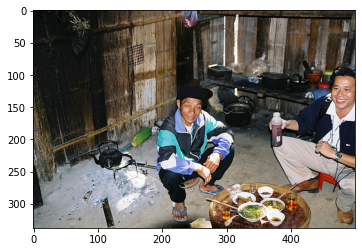

In [31]:
human = cv2.imread('./images/human.jpg',-1)
human=cv2.cvtColor(human, cv2.COLOR_BGR2RGB)
plt.imshow(human)

In [37]:
import json
import pprint

with open('./images/annot.json') as f:
  data = json.load(f)

pprint.pprint(data)

{'flags': {},
 'imageData': None,
 'imageHeight': 338,
 'imagePath': '2011_000003.jpg',
 'imageWidth': 500,
 'shapes': [{'flags': {},
             'group_id': None,
             'label': 'person',
             'points': [[250.8142292490119, 106.96696468940974],
                        [229.8142292490119, 118.96696468940974],
                        [221.8142292490119, 134.96696468940974],
                        [223.8142292490119, 147.96696468940974],
                        [217.8142292490119, 160.96696468940974],
                        [202.8142292490119, 167.96696468940974],
                        [192.8142292490119, 199.96696468940974],
                        [194.8142292490119, 221.96696468940974],
                        [199.8142292490119, 226.96696468940974],
                        [191.8142292490119, 233.96696468940974],
                        [197.8142292490119, 263.9669646894098],
                        [213.8142292490119, 294.9669646894098],
                        [

In [50]:
human_polygon=data["shapes"][0]["points"] # poygon of person


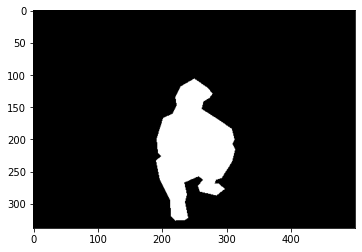

<class 'PIL.Image.Image'>
(500, 338)


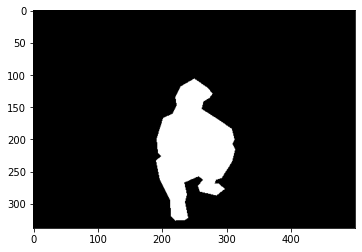

<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [83]:
import PIL.Image
import PIL.ImageDraw

mask=np.zeros(human.shape[:2],dtype=np.uint8) # initialize the mask as 0
mask = PIL.Image.fromarray(mask) 
draw = PIL.ImageDraw.Draw(mask) 

xy = [tuple(point) for point in human_polygon] #convert to polygon
draw.polygon(xy=xy, outline=1, fill=1)
plt.imshow(mask)
plt.show(block=True)

print(type(mask))
print(mask.size)

mask = np.array(mask)

plt.imshow(mask)
plt.show(block=True)
cv2.imwrite
print(type(mask))

print(mask)
outputimg = PIL.Image.fromarray(mask*255)
outputimg.save("./output/human_mask.png","PNG")

#np.save("./output/human_mask.npy",mask)
from scipy.io import savemat
savemat("./output/human_mask.mat",{"mask":mask})

# Ex 3: face detection ignore first


In [32]:
import dlib 
# improve face detection 
face = cv2.imread('marathon.jpg')
plt.imshow(face[:,:,::-1])
plt.show(block=False)

ModuleNotFoundError: No module named 'dlib'

Number of faces detected: 7
Detection 0: Left: 252 Top: 161 Right: 295 Bottom: 204
Detection 1: Left: 818 Top: 204 Right: 861 Bottom: 247
Detection 2: Left: 671 Top: 141 Right: 723 Bottom: 193
Detection 3: Left: 165 Top: 127 Right: 208 Bottom: 170
Detection 4: Left: 429 Top: 146 Right: 472 Bottom: 190
Detection 5: Left: 395 Top: 170 Right: 439 Bottom: 214
Detection 6: Left: 352 Top: 142 Right: 395 Bottom: 185


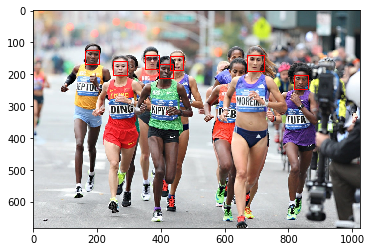

In [ ]:
color = (0, 0, 255) 
thickness = 2

detector = dlib.get_frontal_face_detector()
dets = detector(face, 1)
print("Number of faces detected: {}".format(len(dets)))
for i, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        i, d.left(), d.top(), d.right(), d.bottom()))
    face = cv2.rectangle(face, (d.left(), d.top()), (d.right(), d.bottom()), color, thickness) 

plt.imshow(face[:,:,::-1])
plt.show(block=False)  




In [ ]:
!wget https://www.incimages.com/uploaded_files/image/970x450/getty_938993594_401542.jpg

--2020-02-07 09:24:24--  https://www.incimages.com/uploaded_files/image/970x450/getty_938993594_401542.jpg
Resolving www.incimages.com (www.incimages.com)... 151.101.10.59
Connecting to www.incimages.com (www.incimages.com)|151.101.10.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105420 (103K) [image/jpeg]
Saving to: ‘getty_938993594_401542.jpg’

getty_938993594_401 100%[===================>] 102.95K  --.-KB/s    in 0.008s  

2020-02-07 09:24:29 (13.0 MB/s) - ‘getty_938993594_401542.jpg’ saved [105420/105420]



# Reference

https://www.authentise.com/post/detecting-circular-shapes-using-contours
<br>http://www.robindavid.fr/opencv-tutorial/chapter5-line-edge-and-contours-detection.html
<br>https://pdnotebook.com/image-analysis-intro-using-python-opencv-18791f4edf22
<br>https://circuitdigest.com/tutorial/image-segmentation-using-opencv